In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
# Code for model by Thushan Ganegedara
# LIGHT ON MATH MACHINE LEARNING
# Intuitive Guide to Neural Style Transfer
# An intuitive guide to exploring design choices and technicalities of neural style transfer networks


import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision.utils import save_image
import matplotlib.pyplot as plt


#Loadung the model vgg19 that will serve as the base model
model=models.vgg19(pretrained=True).features
# the vgg19 model has three components :
    #features: containg all the conv, relu and maxpool
    #avgpool: containing the avgpool layer
    #classifier: contains the Dense layer(FC part of the model) 


#Assigning the GPU to the variable device
device=torch.device("cuda")


#[0,5,10,19,28] are the index of the layers we will be using to calculate the loss as per the paper of NST
#Defining a class that for the model
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        #Here we will use the following layers and make an array of their indices
        # 0: block1_conv1
        # 5: block2_conv1
        # 10: block3_conv1
        # 19: block4_conv1
        # 28: block5_conv1
        self.req_features= ['0','5','10','19','28'] 
        #Since we need only the 5 layers in the model so we will be dropping all the rest layers from the features of the model
        self.model=models.vgg19(pretrained=True).features[:29] #model will contain the first 29 layers
    
   
    #x holds the input tensor(image) that will be feeded to each layer
    def forward(self,x):
        #initialize an array that wil hold the activations from the chosen layers
        features=[]
        #Iterate over all the layers of the mode
        for layer_num,layer in enumerate(self.model):
            #activation of the layer will stored in x
            x=layer(x)
            #appending the activation of the selected layers and return the feature array
            if (str(layer_num) in self.req_features):
                features.append(x)
                
        return features



#defing a function that will load the image and perform the required preprocessing and put it on the GPU
def image_loader(path):
    image=Image.open(path)
    #defining the image transformation steps to be performed before feeding them to the model
    loader=transforms.Compose([transforms.Resize((512,512)),transforms.ToTensor()])
    #The preprocessing steps involves resizing the image and then converting it to a tensor

    image=loader(image).unsqueeze(0)
    return image.to(device,torch.float)



#Loading the original and the style image
original_image=image_loader('gdrive/My Drive/Group_Project/nat.jpeg')
style_image=image_loader('gdrive/My Drive/Group_Project/test.jpg')

#Creating the generated image from the original image
generated_image=original_image.clone().requires_grad_(True)

def calc_content_loss(gen_feat,orig_feat):
    #calculating the content loss of each layer by calculating the MSE between the content and generated features and adding it to content loss
    content_l=torch.mean((gen_feat-orig_feat)**2)#*0.5
    return content_l

def calc_style_loss(gen,style):
    #Calculating the gram matrix for the style and the generated image
    batch_size,channel,height,width=gen.shape

    G=torch.mm(gen.view(channel,height*width),gen.view(channel,height*width).t())
    A=torch.mm(style.view(channel,height*width),style.view(channel,height*width).t())
        
    #Calcultating the style loss of each layer by calculating the MSE between the gram matrix of the style image and the generated image and adding it to style loss
    style_l=torch.mean((G-A)**2)#/(4*channel*(height*width)**2)
    return style_l

def calculate_loss(gen_features, orig_feautes, style_featues):
    style_loss=content_loss=0
    for gen,cont,style in zip(gen_features,orig_feautes,style_featues):
        #extracting the dimensions from the generated image
        content_loss+=calc_content_loss(gen,cont)
        style_loss+=calc_style_loss(gen,style)
    
    #calculating the total loss of e th epoch
    total_loss=alpha*content_loss + beta*style_loss 
    return total_loss


#Load the model to the GPU
model=VGG().to(device).eval() 

#initialize the paramerters required for fitting the model
epoch=300
lr=0.004
alpha=8
beta=70

#using adam optimizer and it will update the generated image not the model parameter 
optimizer=optim.Adam([generated_image],lr=lr)

#iterating for 1000 times
for e in range (epoch):
    #extracting the features of generated, content and the original required for calculating the loss
    gen_features=model(generated_image)
    orig_feautes=model(original_image)
    style_featues=model(style_image)
    
    #iterating over the activation of each layer and calculate the loss and add it to the content and the style loss
    total_loss=calculate_loss(gen_features, orig_feautes, style_featues)
    #optimize the pixel values of the generated image and backpropagate the loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    #print the image and save it after each 100 epoch
    if(not (e%100)):
        print(total_loss)
        
        save_image(generated_image,"gen.png")

##############Model code used ends here

tensor(7.3273e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.1845e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.8526e+08, device='cuda:0', grad_fn=<AddBackward0>)


In [10]:
generated_image
save_image(generated_image,"gen.png")
generated_image.shape

torch.Size([1, 3, 512, 512])

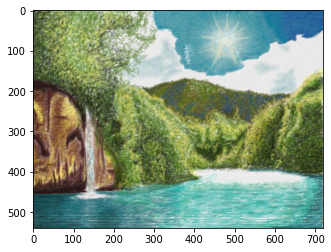

In [11]:
img = Image.open("gdrive/My Drive/Group_Project/nat.jpeg").convert("RGB")
plt.imshow(img)

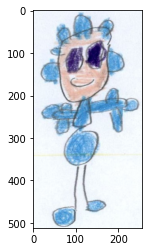

In [12]:
img2 = Image.open("gdrive/My Drive/Group_Project/test.jpg").convert("RGB")
plt.imshow(img2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


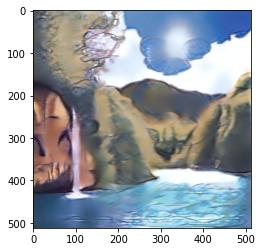

In [13]:
generated_image2 = generated_image.squeeze()
generated_image2.shape
generated_image2 = generated_image2.permute(1,2,0)
generated_image2.shape 
plt.imshow(generated_image2.cpu().detach().numpy())